# Sample Data Generator

This notebook generates synthetic flight data that mimics the BTS structure.
Use this to test the analysis pipeline before downloading real BTS data.

**Note:** This is synthetic data for testing only. For production analysis, use real BTS data.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

print("✓ Imports complete")

✓ Imports complete


## Configuration

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Configuration
NUM_FLIGHTS = 50000  # Number of flights to generate
YEAR = 2024
MONTH = 1

# Top carriers (realistic codes)
CARRIERS = ['AA', 'DL', 'UA', 'WN', 'B6']  # American, Delta, United, Southwest, JetBlue

# Top airports
AIRPORTS = ['ATL', 'DFW', 'DEN', 'ORD', 'LAX', 'CLT', 'MCO', 'LAS', 'PHX', 'SEA']

# Carrier-specific delay characteristics (mean delay in minutes)
CARRIER_DELAY_MEANS = {
    'AA': 8.5,
    'DL': 6.2,
    'UA': 9.1,
    'WN': 7.8,
    'B6': 11.3
}

print(f"Generating {NUM_FLIGHTS:,} flights for {MONTH}/{YEAR}")
print(f"Carriers: {CARRIERS}")
print(f"Airports: {AIRPORTS}")

Generating 50,000 flights for 1/2024
Carriers: ['AA', 'DL', 'UA', 'WN', 'B6']
Airports: ['ATL', 'DFW', 'DEN', 'ORD', 'LAX', 'CLT', 'MCO', 'LAS', 'PHX', 'SEA']


## Generate Flight Data

In [3]:
# Generate base data
data = {
    'Year': [YEAR] * NUM_FLIGHTS,
    'Month': [MONTH] * NUM_FLIGHTS,
    'DayofMonth': np.random.randint(1, 32, NUM_FLIGHTS),
    'Carrier': np.random.choice(CARRIERS, NUM_FLIGHTS),
    'Origin': np.random.choice(AIRPORTS, NUM_FLIGHTS),
    'Dest': np.random.choice(AIRPORTS, NUM_FLIGHTS),
    'Distance': np.random.randint(200, 3000, NUM_FLIGHTS),
    'Cancelled': np.random.choice([0, 1], NUM_FLIGHTS, p=[0.98, 0.02]),
    'Diverted': np.random.choice([0, 1], NUM_FLIGHTS, p=[0.995, 0.005])
}

df = pd.DataFrame(data)

print(f"✓ Base data generated: {len(df):,} rows")

✓ Base data generated: 50,000 rows


## Generate Realistic Delay Data

Delays are modeled with:
- Carrier-specific mean delays
- Positive skew (occasional very long delays)
- Distance correlation (slight increase with distance)
- Random noise

In [4]:
# Generate delays with carrier-specific characteristics
def generate_delay(carrier, distance):
    """Generate realistic delay with carrier-specific mean and distance factor"""
    base_delay = CARRIER_DELAY_MEANS[carrier]
    distance_factor = distance / 1000  # Slight increase with distance
    
    # Use gamma distribution for positive skew (occasional long delays)
    delay = np.random.gamma(2, base_delay/2) + distance_factor
    
    # Add chance of early arrival (negative delay)
    if np.random.random() < 0.3:
        delay = -np.random.uniform(0, 15)
    
    return delay

# Apply delay generation
df['ArrDelay'] = df.apply(
    lambda row: generate_delay(row['Carrier'], row['Distance']), 
    axis=1
)

# Departure delay is correlated with arrival delay
df['DepDelay'] = df['ArrDelay'] + np.random.normal(0, 5, NUM_FLIGHTS)

# Set delays to NaN for cancelled/diverted flights
df.loc[df['Cancelled'] == 1, ['ArrDelay', 'DepDelay']] = np.nan
df.loc[df['Diverted'] == 1, ['ArrDelay', 'DepDelay']] = np.nan

print(f"✓ Delay data generated")
print(f"  • Mean arrival delay: {df['ArrDelay'].mean():.1f} minutes")
print(f"  • Median arrival delay: {df['ArrDelay'].median():.1f} minutes")
print(f"  • Std arrival delay: {df['ArrDelay'].std():.1f} minutes")

✓ Delay data generated
  • Mean arrival delay: 4.8 minutes
  • Median arrival delay: 5.9 minutes
  • Std arrival delay: 10.0 minutes


## Data Quality Check

In [5]:
print("Data Quality Summary:\n")
print(df.info())
print("\nFirst 10 rows:")
display(df.head(10))

print("\nDelay Statistics by Carrier:")
carrier_stats = df.groupby('Carrier')['ArrDelay'].agg(['mean', 'median', 'std', 'count'])
display(carrier_stats.sort_values('mean'))

Data Quality Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        50000 non-null  int64  
 1   Month       50000 non-null  int64  
 2   DayofMonth  50000 non-null  int64  
 3   Carrier     50000 non-null  object 
 4   Origin      50000 non-null  object 
 5   Dest        50000 non-null  object 
 6   Distance    50000 non-null  int64  
 7   Cancelled   50000 non-null  int64  
 8   Diverted    50000 non-null  int64  
 9   ArrDelay    48755 non-null  float64
 10  DepDelay    48755 non-null  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 4.2+ MB
None

First 10 rows:


,Year,Month,DayofMonth,Carrier,Origin,Dest,Distance,Cancelled,Diverted,ArrDelay,DepDelay
0,2024,1,7,B6,DFW,LAS,276,0,0,3.477576,5.850242
1,2024,1,20,B6,DEN,ORD,2992,0,0,8.088139,2.337261
2,2024,1,29,WN,LAX,PHX,1840,0,0,2.568314,0.447216
3,2024,1,15,WN,LAS,DFW,2491,0,0,15.854559,16.430705
4,2024,1,11,B6,PHX,LAS,1335,0,0,15.396932,14.511776
5,2024,1,8,DL,ORD,PHX,2223,0,0,6.742422,11.858576
6,2024,1,29,AA,CLT,CLT,2556,0,0,-10.711002,-10.562375
7,2024,1,21,UA,ORD,LAS,1502,0,0,-9.719120,-5.299863
8,2024,1,7,WN,PHX,ORD,2870,0,0,-4.815500,-6.816052
9,2024,1,26,AA,LAX,SEA,2492,0,0,10.841667,15.443139



Delay Statistics by Carrier:


,mean,median,std,count
Carrier,,,,
DL,3.292466,4.930140,8.281100,9862
WN,4.212635,5.698792,9.442543,9824
AA,4.714814,5.967445,9.878811,9739
UA,5.112640,6.346458,10.212413,9603
B6,6.615305,7.467895,11.670381,9727


## Export Sample Data

In [6]:
# Save to data directory
output_path = '../data/airline_ontime.csv'
df.to_csv(output_path, index=False)

print(f"✓ Sample data exported to: {output_path}")
print(f"✓ File size: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"✓ Total rows: {len(df):,}")
print("\n📝 Next step: Run analysis.ipynb to analyze this data")

✓ Sample data exported to: ../data/airline_ontime.csv
✓ File size: 10.4 MB
✓ Total rows: 50,000

📝 Next step: Run analysis.ipynb to analyze this data


## Validation: Check Delay Distribution

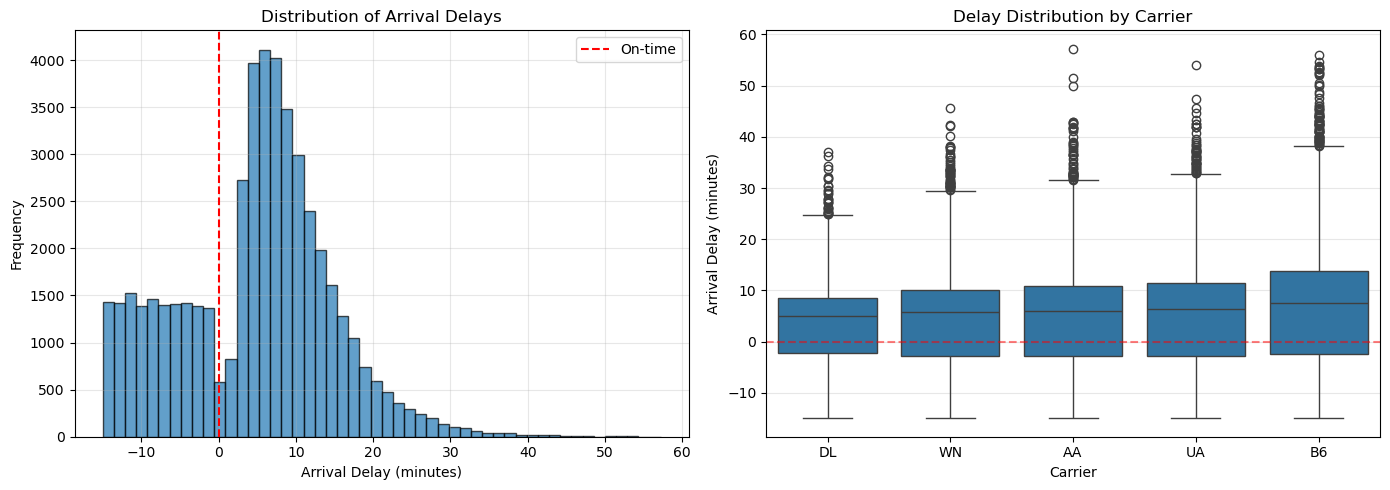

✓ Validation plot saved to outputs/sample_data_validation.png


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of delays
axes[0].hist(df['ArrDelay'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='On-time')
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delays')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by carrier
df_plot = df[df['ArrDelay'].notna()]
carrier_order = df_plot.groupby('Carrier')['ArrDelay'].median().sort_values().index
sns.boxplot(data=df_plot, x='Carrier', y='ArrDelay', order=carrier_order, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Carrier')
axes[1].set_ylabel('Arrival Delay (minutes)')
axes[1].set_title('Delay Distribution by Carrier')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/sample_data_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Validation plot saved to outputs/sample_data_validation.png")